In [292]:
# !pip install farasapy
# !pip install datasets

In [387]:

import spacy
import networkx as nx
import matplotlib.pyplot as plt
nlp = spacy.load("en_core_web_sm")
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.layers import Embedding , Dense, Dropout, LSTM, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
from datasets import load_dataset
import random
from farasa.pos import FarasaPOSTagger
from tensorflow.keras.layers import TimeDistributed , MaxPooling1D , Conv1D





## I- Use built-in Library

In [294]:
sentence = "A plan is being prepared by charles for next project"
doc = nlp(sentence)
tokens = [token.text for token in doc]

- Graph words

In [295]:
pos_tags = [token.pos_ for token in doc]
pos_tags

['DET', 'NOUN', 'AUX', 'AUX', 'VERB', 'ADP', 'NOUN', 'ADP', 'ADJ', 'NOUN']

In [296]:
G = nx.DiGraph()
for i in range(len(tokens)):
    G.add_node(tokens[i], pos=pos_tags[i])
for i in range(len(tokens)-1):
    G.add_edge(tokens[i], tokens[i+1])


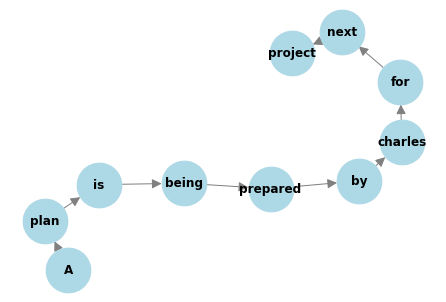

In [297]:
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, font_weight='bold', node_size=2000, node_color='lightblue', edge_color='gray', arrowsize=20)
nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'pos'), font_color='red', font_size=10)
plt.show()


- Graph words & Tags

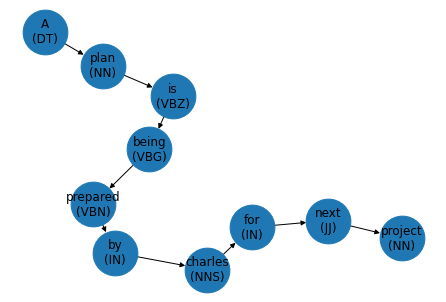

In [298]:
# POS tag the tokens
tagged = nltk.pos_tag(tokens)

# Create a directed graph
graph = nx.DiGraph()

# Add nodes for each word and its POS tag
for word, pos in tagged:
    node_label = f"{word}\n({pos})"  
    graph.add_node(node_label)

# Add edges between adjacent words
for i in range(len(tagged) - 1):
    start_label = f"{tagged[i][0]}\n({tagged[i][1]})"
    end_label = f"{tagged[i+1][0]}\n({tagged[i+1][1]})"
    graph.add_edge(start_label, end_label)


pos = nx.spring_layout(graph, seed=42) 
nx.draw(graph, pos, with_labels=True,node_size=2000)


## II- Brown dataset and DNN

In [299]:
import re

data = []  # list to store the parsed data

with open('brown/browntag_nolines.txt', 'r') as file:
    for line in file:
        line = line.strip()  
        words = line.split()  
        sentence = []
        for word in words:
            match = re.match(r'(.+)_([A-Z]+)', word)  
            if match:
                sentence.append((match.group(1).lower(), match.group(2)))  # add word and POS tag to sentence
        
        data.append(sentence)  


In [300]:
data

[[('the', 'AT'),
  ('fulton', 'NP'),
  ('county', 'NN'),
  ('grand', 'JJ'),
  ('jury', 'NN'),
  ('said', 'VBD'),
  ('friday', 'NR'),
  ('an', 'AT'),
  ('investigation', 'NN'),
  ('of', 'IN'),
  ("atlanta's", 'NP'),
  ('recent', 'JJ'),
  ('primary', 'NN'),
  ('election', 'NN'),
  ('produced', 'VBD'),
  ('no', 'AT'),
  ('evidence', 'NN'),
  ('that', 'CS'),
  ('any', 'DTI'),
  ('irregularities', 'NNS'),
  ('took', 'VBD'),
  ('place', 'NN')],
 [('the', 'AT'),
  ('jury', 'NN'),
  ('further', 'RBR'),
  ('said', 'VBD'),
  ('in', 'IN'),
  ('term-end', 'NN'),
  ('presentments', 'NNS'),
  ('that', 'CS'),
  ('the', 'AT'),
  ('city', 'NN'),
  ('executive', 'JJ'),
  ('committee', 'NN'),
  ('which', 'WDT'),
  ('had', 'HVD'),
  ('over-all', 'JJ'),
  ('charge', 'NN'),
  ('of', 'IN'),
  ('the', 'AT'),
  ('election', 'NN'),
  ('deserves', 'VBZ'),
  ('the', 'AT'),
  ('praise', 'NN'),
  ('and', 'CC'),
  ('thanks', 'NNS'),
  ('of', 'IN'),
  ('the', 'AT'),
  ('city', 'NN'),
  ('of', 'IN'),
  ('atlanta', 'NP

In [301]:
print(len(data))

57067


- lemmization 

In [302]:
lemmatizer = WordNetLemmatizer()

def lemmatize_sentence(sentence):
    lemmatized_sen = []
    txt = []
    tag = []
    for word in sentence :
        lemmatized_word = lemmatizer.lemmatize(word[0])
        lemmatized_sen.append((lemmatized_word,word[1]))
        txt.append(lemmatized_word)
        tag.append(word[1])
    text_data = ' '.join(txt)
    return lemmatized_sen , text_data , tag


data_lemmatized = []
txt_sen_clean = []
all_tags = []
for sentence in data:
    txt_lemm , text_data , tag = lemmatize_sentence(sentence)
    data_lemmatized.append(txt_lemm)
    txt_sen_clean.append(text_data)
    all_tags.append(tag)
    
# data_lemmatized = [lemmatize_sentence(sentence) for sentence in data]
# data_lemmatized


  7%|▋         | 17.1M/241M [19:35:45<257:24:05, 242iB/s]
  3%|▎         | 6.83M/241M [19:33:54<671:50:11, 96.9iB/s]


In [303]:
print(data_lemmatized[:2])
print(txt_sen_clean[:2])
print(all_tags[:2])

print(len(data_lemmatized))
print(len(txt_sen_clean))
print(len(all_tags))

[[('the', 'AT'), ('fulton', 'NP'), ('county', 'NN'), ('grand', 'JJ'), ('jury', 'NN'), ('said', 'VBD'), ('friday', 'NR'), ('an', 'AT'), ('investigation', 'NN'), ('of', 'IN'), ("atlanta's", 'NP'), ('recent', 'JJ'), ('primary', 'NN'), ('election', 'NN'), ('produced', 'VBD'), ('no', 'AT'), ('evidence', 'NN'), ('that', 'CS'), ('any', 'DTI'), ('irregularity', 'NNS'), ('took', 'VBD'), ('place', 'NN')], [('the', 'AT'), ('jury', 'NN'), ('further', 'RBR'), ('said', 'VBD'), ('in', 'IN'), ('term-end', 'NN'), ('presentment', 'NNS'), ('that', 'CS'), ('the', 'AT'), ('city', 'NN'), ('executive', 'JJ'), ('committee', 'NN'), ('which', 'WDT'), ('had', 'HVD'), ('over-all', 'JJ'), ('charge', 'NN'), ('of', 'IN'), ('the', 'AT'), ('election', 'NN'), ('deserves', 'VBZ'), ('the', 'AT'), ('praise', 'NN'), ('and', 'CC'), ('thanks', 'NNS'), ('of', 'IN'), ('the', 'AT'), ('city', 'NN'), ('of', 'IN'), ('atlanta', 'NP'), ('for', 'IN'), ('the', 'AT'), ('manner', 'NN'), ('in', 'IN'), ('which', 'WDT'), ('the', 'AT'), ('e

In [304]:
unique_tags = set()
for sen_tag in all_tags:
    for tag in sen_tag:
        unique_tags.add(tag)
num_tags = len(unique_tags)

In [305]:
tag_dict = {tag: index for index, tag in enumerate(unique_tags)}
# tag_dict

In [306]:
tags = [[tag for _, tag in sentence] for sentence in data]
# tags[0]

- Word embedding

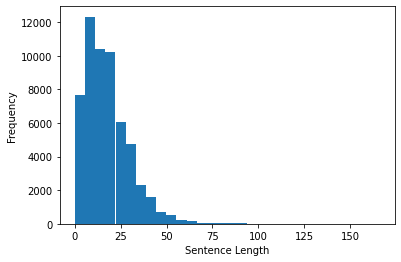

In [307]:
sentence_lengths = [len(s.split()) for s in txt_sen_clean]


plt.hist(sentence_lengths, bins=30)
plt.xlabel("Sentence Length")
plt.ylabel("Frequency")
plt.show()    

In [308]:
num_records_100 = sum([1 for record in sentence_lengths if record > 100])
num_records_50 = sum([1 for record in sentence_lengths if record > 50])

print("num of records :", num_records_100 , " - with % : ", num_records_100 / len(sentence_lengths))
print("num of records :", num_records_50 , " - with % : ", num_records_50 / len(sentence_lengths))

num of records : 20  - with % :  0.0003504652426095642
num of records : 947  - with % :  0.016594529237562865


In [309]:
unique_words = set()
for sentence in txt_sen_clean:
    words = sentence.split()
    for word in words:
        unique_words.add(word)

num_unique_words = len(unique_words)
print(num_unique_words)

44201


In [310]:
max_len = 50 
num_words = 44201


In [311]:
tag_numbers = [[tag_dict[tag] for tag in sentence] for sentence in all_tags]
tag_dict["<pad>"] = len(tag_dict)
tag_dict[''] = len(tag_dict)
len(tag_dict)
len(tag_numbers[0])

22

In [312]:
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(txt_sen_clean)
tokenized_sen = tokenizer.texts_to_sequences(txt_sen_clean)
padded_sen = pad_sequences(tokenized_sen, maxlen=max_len, padding='post', truncating='post', value=0)
padded_tags = pad_sequences(tag_numbers, maxlen=max_len, padding='post', truncating='post')


In [313]:
# Define the embedding dimension
embedding_dim = 100
embedding_layer = Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=max_len)
embedded_sen = embedding_layer(padded_sen)


In [314]:
print(len(embedded_sen[0]))
print(len(padded_tags[0]))

50
50


- Split Train , Test

In [315]:
x = np.array(embedded_sen)
y = np.array(padded_tags)


In [316]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


In [317]:
print(x_train[0])
print(y_train[0])
print(len(x_train[0]))
print(len(y_train[0]))
print(len(x_train[0][0]))




[[ 0.04656826  0.03690619 -0.02435875 ... -0.01573086 -0.0418003
  -0.02837214]
 [ 0.01623602 -0.01421911  0.04880986 ... -0.04142164  0.0464184
   0.04971547]
 [-0.00807633  0.03807387 -0.03536971 ...  0.03167846 -0.03400165
   0.01980009]
 ...
 [ 0.03916496  0.02900154 -0.00579333 ... -0.01095752 -0.03734114
  -0.0341812 ]
 [ 0.03916496  0.02900154 -0.00579333 ... -0.01095752 -0.03734114
  -0.0341812 ]
 [ 0.03916496  0.02900154 -0.00579333 ... -0.01095752 -0.03734114
  -0.0341812 ]]
[59 52 38  5 15  1 38  9 64 11 59  4 11 11  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0]
50
50
100


- Train model

In [318]:
model = Sequential()
model.add(LSTM(units=64, input_shape=(max_len, embedding_dim), return_sequences=True))
model.add(Dense(len(tag_dict), activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()



Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_43 (LSTM)              (None, 50, 64)            42240     
                                                                 
 dense_40 (Dense)            (None, 50, 72)            4680      
                                                                 
Total params: 46,920
Trainable params: 46,920
Non-trainable params: 0
_________________________________________________________________


In [319]:
logdir="log/"

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

chkpt = ModelCheckpoint("model_weights.h5", monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True, mode='min')

early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=0, mode='max', baseline=None, restore_best_weights=True)

callbacks = [early_stopping,chkpt,tensorboard_callback]

history=model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test),callbacks=callbacks)


Epoch 1/50
1427/1427 [==============================] - ETA: 0s - loss: 1.1498 - accuracy: 0.7274
Epoch 1: val_loss improved from inf to 0.90994, saving model to model_weights.h5
1427/1427 [==============================] - 32s 19ms/step - loss: 1.1498 - accuracy: 0.7274 - val_loss: 0.9099 - val_accuracy: 0.7693
Epoch 2/50
1425/1427 [============================>.] - ETA: 0s - loss: 0.7936 - accuracy: 0.7982
Epoch 2: val_loss improved from 0.90994 to 0.70517, saving model to model_weights.h5
1427/1427 [==============================] - 26s 18ms/step - loss: 0.7936 - accuracy: 0.7982 - val_loss: 0.7052 - val_accuracy: 0.8188
Epoch 3/50
1426/1427 [============================>.] - ETA: 0s - loss: 0.6579 - accuracy: 0.8302
Epoch 3: val_loss improved from 0.70517 to 0.61577, saving model to model_weights.h5
1427/1427 [==============================] - 26s 19ms/step - loss: 0.6579 - accuracy: 0.8302 - val_loss: 0.6158 - val_accuracy: 0.8395
Epoch 4/50
1425/1427 [============================

In [320]:
model.save('pos.h5')

In [321]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

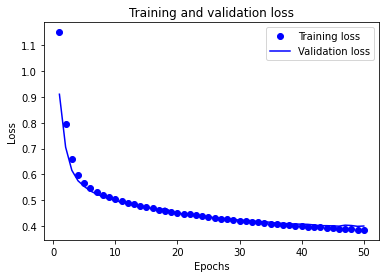

In [322]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')

plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

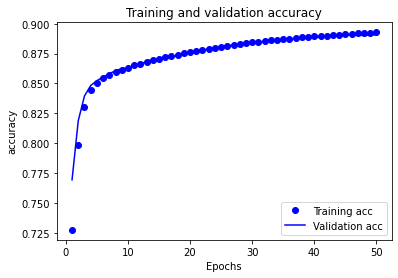

In [323]:
plt.clf()   # clear figure

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()

plt.show()

- Evaluate model

In [324]:
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=128)
print("test loss: {} ".format(results[0]))
print("test accuracy: {} ".format(results[1]))

Evaluate on test data
90/90 [==============================] - 3s 29ms/step - loss: 0.4003 - accuracy: 0.8905
test loss: 0.40028783679008484 
test accuracy: 0.8905466794967651 


- Print Prediction

In [325]:
reverse_tag_dict = {v: k for k, v in tag_dict.items()}

In [326]:
word_index = tokenizer.word_index
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
embedding_weights = embedding_layer.get_weights()[0]

In [327]:
def get_original_sen(x_test,reverse_word_index):
    embedded_sentence = x_test
    word_indices = np.argmax(embedded_sentence, axis=-1)
    words = [reverse_word_index.get(i, '<UNK>') for i in word_indices]
    original_sentence = ' '.join(words)
    return original_sentence

In [328]:
def get_tags(reverse_tag_dict,y_true,y_predict):
    tag_true_list = [reverse_tag_dict[val] for val in y_true]
    tag_predict_list = [reverse_tag_dict[val] for val in y_predict]
    return tag_true_list , tag_predict_list

In [329]:
def predict(x,model):
    p = model.predict(np.array([x]))
    p = np.argmax(p, axis=-1)
    y_predict = p[0]
    return y_predict  

In [330]:
def predict_and_display(x,y,model,reverse_word_index,reverse_tag_dict):
    y_predict  = predict(x,model)
    original_sen = get_original_sen(x,reverse_word_index)
    true_tag , predicted_tag = get_tags(reverse_tag_dict,y,y_predict)
    return original_sen , true_tag , predicted_tag

In [331]:
y_predict  = predict(x_test[0],model)

1/1 [==============================] - 1s 518ms/step


In [332]:
original_sen , true_tag , predicted_tag = predict_and_display(x_test[0],y_test[0],model,reverse_word_index,reverse_tag_dict)


original_sen_lst = original_sen.split()
print('original sentence','\t','true tag','\t','predicted tag')
for i in range(len(true_tag)):
    
    print(original_sen_lst[i],'\t\t\t',true_tag[i],'\t\t\t',predicted_tag[i])

1/1 [==============================] - 0s 100ms/step
original sentence 	 true tag 	 predicted tag
me 			 AT 			 AT
the 			 NN 			 NN
or 			 NN 			 NN
all 			 WDT 			 WDT
been 			 BEZ 			 BEZ
they 			 JJ 			 JJ
be 			 IN 			 IN
me 			 AT 			 AT
we 			 CD 			 NN
also 			 NN 			 NN
must 			 MD 			 MD
that 			 BE 			 BE
other 			 VBN 			 VBN
or 			 RBT 			 JJT
most 			 IN 			 IN
me 			 AT 			 AT
and 			 NN 			 NN
new 			 IN 			 IN
these 			 JJ 			 NN
made 			 NNS 			 NN
time 			 TO 			 TO
time 			 TO 			 TO
time 			 TO 			 TO
time 			 TO 			 TO
time 			 TO 			 TO
time 			 TO 			 TO
time 			 TO 			 TO
time 			 TO 			 TO
time 			 TO 			 TO
time 			 TO 			 TO
time 			 TO 			 TO
time 			 TO 			 TO
time 			 TO 			 TO
time 			 TO 			 TO
time 			 TO 			 TO
time 			 TO 			 TO
time 			 TO 			 TO
time 			 TO 			 TO
time 			 TO 			 TO
time 			 TO 			 TO
time 			 TO 			 TO
time 			 TO 			 TO
time 			 TO 			 TO
time 			 TO 			 TO
time 			 TO 			 TO
time 			 TO 			 TO
time 			 TO 			 TO
time 			 TO 			 

- Confusion matrix

In [333]:
from sklearn.metrics import confusion_matrix
import pandas as pd 

In [334]:
y_predict_lst = []
for record in x_test:
    y_predict_lst.append(predict(record,model))
y_true_lst =y_test

y_true_flat = np.reshape(y_true_lst, (-1,))
y_predict_flat = np.reshape(y_predict_lst, (-1,))

# Compute confusion matrix
tag_true_list , tag_predict_list = get_tags(reverse_tag_dict,y_true_flat,y_predict_flat)
cm = confusion_matrix(tag_true_list, tag_predict_list)


1/1 [==============================] - 0s 121ms/step


In [335]:
cm_df = pd.DataFrame(cm)
pd.set_option('display.max_columns',9999)
pd.set_option('display.width',9999)
cm_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68
0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,55,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,9,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,527,0,7,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,8,0,0,0,0,0,24,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,5,0,0,1,0,2,0,0,0,0,0,0,0
2,0,0,128,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,9,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,1,0,1531,28,0,0,1,0,0,0,1,0,17,2,2,1,0,0,2,2,0,0,0,0,1,0,0,0,0,33,72,0,0,0,0,71,8,4,0,0,0,0,1,0,0,0,1,0,0,76,7,36,3,0,0,8,0,4,2,1,2,0,0,0,0,0,0,0
4,0,3,0,4,18111,6,1,11,1,0,1,3,14,62,13,187,1,0,0,3,0,0,0,1,0,8,1,0,0,3,585,47,1,0,0,8,469,20,24,0,1,0,1,0,1,1,0,2,2,0,0,0,29,0,0,0,88,0,40,22,1,18,3,8,0,0,1,0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,42,0,0,0,0
65,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21,0,0,0,1,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,22,6,0,0
66,0,1,0,1,1,0,0,0,0,0,0,0,0,2,2,192,0,0,0,6,0,5,0,0,0,1,0,0,0,0,4,6,0,0,0,0,43,8,7,0,0,0,0,0,1,0,0,0,1,1,0,0,2,0,0,0,3,0,2,2,0,0,0,4,0,0,512,0,0
67,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,29


In [336]:
from sklearn.metrics import f1_score

f1 = f1_score(tag_true_list, tag_predict_list,average='micro')
f1

0.8905466970387244

## Arabic

In [337]:
dataset = load_dataset("arabic_pos_dialect",'egy')

Found cached dataset arabic_pos_dialect (C:/Users/Cybral-1/.cache/huggingface/datasets/arabic_pos_dialect/egy/0.0.0/2a3f328dec12474f2c2ae358a42f7b800cd71f968351f90454b68728c7692b31)


  0%|          | 0/1 [00:00<?, ?it/s]

In [338]:
dataset['train']

Dataset({
    features: ['fold', 'subfold', 'words', 'segments', 'pos_tags'],
    num_rows: 350
})

In [339]:
df = pd.DataFrame(dataset['train'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   fold      350 non-null    int64 
 1   subfold   350 non-null    object
 2   words     350 non-null    object
 3   segments  350 non-null    object
 4   pos_tags  350 non-null    object
dtypes: int64(1), object(4)
memory usage: 13.8+ KB


In [340]:
df.head(2)

,fold,subfold,words,segments,pos_tags
0,4,A,"[ليه, لما, تحب, حد, من, قلبك, يطلع, واطى, ليه,...","[ليه, لما, تحب, حد, من, قلب+ك, يطلع, واطى, ليه...","[PART, PART, V, NOUN, PREP, NOUN+PRON, V, ADJ,..."
1,4,A,"[عارف, بيقولك, ايه, "", إذا, أخطأت, فأحسن, "", ....","[عارف, ب+يقو+ل+ك, ايه, "", إذا, أخطأ+ت, ف+أحسن,...","[ADJ, PROG_PART+V+PREP+PRON, PART, PUNC, PART,..."


In [341]:
print(df['words'][0])
print(df['segments'][0])

['ليه', 'لما', 'تحب', 'حد', 'من', 'قلبك', 'يطلع', 'واطى', 'ليه', 'لما', 'تلعب', 'على', 'واحد', 'يطلع', 'بيحبك', 'ليه', 'اللى', 'هيموت', 'عليك', 'انت', 'مش', 'طايقه', 'واللى', 'هتموت', 'عليه', 'مش', 'طايقك', 'عجبت', 'لك', 'يا', 'زمن', 'EOS']
['ليه', 'لما', 'تحب', 'حد', 'من', 'قلب+ك', 'يطلع', 'واطى', 'ليه', 'لما', 'تلعب', 'على', 'واحد', 'يطلع', 'ب+يحب+ك', 'ليه', 'اللى', 'ه+يموت', 'علي+ك', 'انت', 'مش', 'طايق+ه', 'و+اللى', 'ه+تموت', 'علي+ه', 'مش', 'طايق+ك', 'عجب+ت', 'ل+ك', 'يا', 'زمن', 'EOS']


In [342]:
lemmatizer = WordNetLemmatizer()

In [343]:
def lemmatize_arabic(words,pos):
    lemmatized_sen = []
    txt = []
    tag = []
    for i in range(len(words)):
        lemmatized_word = lemmatizer.lemmatize(words[i])
        lemmatized_sen.append((lemmatized_word,pos[i]))
        txt.append(lemmatized_word)
        tag.append(pos[i])
    text_data = ' '.join(txt)
    return lemmatized_sen , text_data , tag


In [344]:
for i in range(len(df['pos_tags'])):
    lst=[]
    for pos in df['pos_tags'][i]:
        lst.append(pos.split('+')[0])
    df['pos_tags'][i] = lst

C:\Users\Cybral-1\AppData\Local\Temp/ipykernel_11272/3389681953.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pos_tags'][i] = lst


In [346]:
data_lemmatized_a = []
txt_sen_clean_a = []
all_tags_a = []
for ind in df.index:
    sen,txt,tag = lemmatize_arabic(df['words'][ind], df['pos_tags'][ind])
    data_lemmatized_a.append(sen)
    txt_sen_clean_a.append(txt)
    all_tags_a.append(tag)
    
    

In [347]:
print(data_lemmatized_a[:2])
print(txt_sen_clean_a[:2])
print(all_tags_a[:2])

print(len(data_lemmatized_a))
print(len(txt_sen_clean_a))
print(len(all_tags_a))

[[('ليه', 'PART'), ('لما', 'PART'), ('تحب', 'V'), ('حد', 'NOUN'), ('من', 'PREP'), ('قلبك', 'NOUN'), ('يطلع', 'V'), ('واطى', 'ADJ'), ('ليه', 'PART'), ('لما', 'PART'), ('تلعب', 'V'), ('على', 'PREP'), ('واحد', 'NOUN'), ('يطلع', 'V'), ('بيحبك', 'PROG_PART'), ('ليه', 'PART'), ('اللى', 'PART'), ('هيموت', 'FUT_PART'), ('عليك', 'PREP'), ('انت', 'PRON'), ('مش', 'PART'), ('طايقه', 'ADJ'), ('واللى', 'CONJ'), ('هتموت', 'FUT_PART'), ('عليه', 'PREP'), ('مش', 'PART'), ('طايقك', 'ADJ'), ('عجبت', 'V'), ('لك', 'PREP'), ('يا', 'PART'), ('زمن', 'NOUN'), ('EOS', 'EOS')], [('عارف', 'ADJ'), ('بيقولك', 'PROG_PART'), ('ايه', 'PART'), ('"', 'PUNC'), ('إذا', 'PART'), ('أخطأت', 'V'), ('فأحسن', 'CONJ'), ('"', 'PUNC'), ('.', 'PUNC'), ('.', 'PUNC'), ('يعني', 'V'), ('متعندش', 'PART'), ('.', 'PUNC'), ('.', 'PUNC'), ('و', 'CONJ'), ('متسألش', 'PART'), ('مين', 'PART'), ('اللي', 'PART'), ('بيقولك', 'PROG_PART'), ('.', 'PUNC'), ('EOS', 'EOS')]]
['ليه لما تحب حد من قلبك يطلع واطى ليه لما تلعب على واحد يطلع بيحبك ليه اللى هي

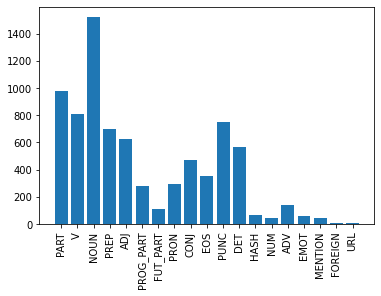

In [348]:
from collections import Counter

flat_data = [item for sublist in all_tags_a for item in sublist]

# Count the occurrences of each value
counts = Counter(flat_data)

# Create a bar plot of the counts
plt.bar(counts.keys(), counts.values())
plt.xticks(rotation=90)
plt.show()

In [349]:
unique_tags_a = set()
for sen_tag in all_tags_a:
    for tag in sen_tag:
        unique_tags_a.add(tag)
num_tags_a = len(unique_tags_a)
num_tags_a

19

In [350]:
tag_dict_a = {tag: index for index, tag in enumerate(unique_tags_a)}
tag_dict_a

{'NUM': 0,
 'HASH': 1,
 'PUNC': 2,
 'PREP': 3,
 'FUT_PART': 4,
 'MENTION': 5,
 'EOS': 6,
 'CONJ': 7,
 'PRON': 8,
 'NOUN': 9,
 'DET': 10,
 'V': 11,
 'FOREIGN': 12,
 'ADJ': 13,
 'PART': 14,
 'ADV': 15,
 'URL': 16,
 'EMOT': 17,
 'PROG_PART': 18}

In [351]:
tags_a = [[tag for _, tag in sentence] for sentence in data_lemmatized_a]


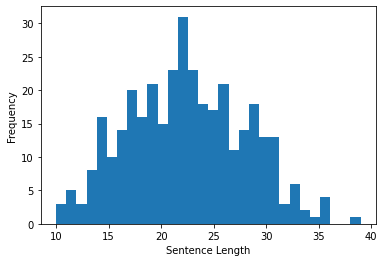

In [352]:
sentence_lengths_a = [len(s.split()) for s in txt_sen_clean_a]


plt.hist(sentence_lengths_a, bins=30)
plt.xlabel("Sentence Length")
plt.ylabel("Frequency")
plt.show()    

In [353]:
num_records_35 = sum([1 for record in sentence_lengths_a if record > 35])
num_records_30 = sum([1 for record in sentence_lengths_a if record > 30])

print("num of records :", num_records_100 , " - with % : ", num_records_35 / len(sentence_lengths_a))
print("num of records :", num_records_50 , " - with % : ", num_records_30 / len(sentence_lengths_a))

num of records : 20  - with % :  0.014285714285714285
num of records : 947  - with % :  0.08571428571428572


In [354]:
unique_words_a = set()
for sentence in txt_sen_clean_a:
    words = sentence.split()
    for word in words:
        unique_words_a.add(word)

num_unique_words_a = len(unique_words_a)
print(num_unique_words_a)

3238


In [355]:
max_len_a = 30 
num_words_a = num_unique_words_a


In [356]:
tag_numbers_a = [[tag_dict_a[tag] for tag in sentence] for sentence in all_tags_a]
tag_dict_a["<pad>"] = len(tag_dict_a)
# tag_dict[''] = len(tag_dict)
len(tag_dict_a)
len(tag_numbers_a[0])

32

In [357]:
tokenizer_a = Tokenizer(num_words=num_words_a)
tokenizer_a.fit_on_texts(txt_sen_clean_a)
tokenized_sen_a = tokenizer_a.texts_to_sequences(txt_sen_clean_a)
padded_sen_a = pad_sequences(tokenized_sen_a, maxlen=max_len_a, padding='post', truncating='post', value=0)
padded_tags_a = pad_sequences(tag_numbers_a, maxlen=max_len_a, padding='post', truncating='post')


In [358]:
# Define the embedding dimension
embedding_dim_a = 100
embedding_layer_a = Embedding(input_dim=num_words_a, output_dim=embedding_dim_a, input_length=max_len_a)
embedded_sen_a = embedding_layer_a(padded_sen_a)


In [359]:
print(len(embedded_sen_a[0]))
print(len(padded_tags_a[0]))

30
30


In [360]:
x_a = np.array(embedded_sen_a)
y_a = np.array(padded_tags_a)


In [361]:
x_train_a, x_test_a, y_train_a, y_test_a = train_test_split(x_a, y_a, test_size=0.1, random_state=42)


In [362]:
print(len(x_train_a[0]))
print(len(y_train_a[0]))


30
30


- Model 1

In [392]:
model = Sequential()
model.add(LSTM(units=64, input_shape=(max_len_a, embedding_dim_a), return_sequences=True))
model.add(Dense(len(tag_dict_a), activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()



Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_56 (LSTM)              (None, 30, 64)            42240     
                                                                 
 dense_50 (Dense)            (None, 30, 20)            1300      
                                                                 
Total params: 43,540
Trainable params: 43,540
Non-trainable params: 0
_________________________________________________________________


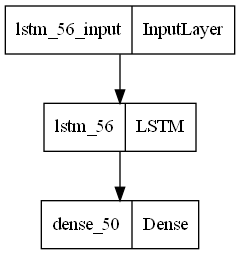

In [393]:
plot_model(model)

In [394]:
history_a=model.fit(x_train_a, y_train_a, epochs=50, batch_size=32, validation_data=(x_test_a, y_test_a))


Epoch 1/50
10/10 [==============================] - 10s 330ms/step - loss: 2.9566 - accuracy: 0.2347 - val_loss: 2.8763 - val_accuracy: 0.3238
Epoch 2/50
10/10 [==============================] - 1s 127ms/step - loss: 2.7621 - accuracy: 0.2642 - val_loss: 2.3751 - val_accuracy: 0.3152
Epoch 3/50
10/10 [==============================] - 1s 123ms/step - loss: 2.4279 - accuracy: 0.2623 - val_loss: 2.1776 - val_accuracy: 0.3190
Epoch 4/50
10/10 [==============================] - 1s 139ms/step - loss: 2.3305 - accuracy: 0.2730 - val_loss: 2.1840 - val_accuracy: 0.3410
Epoch 5/50
10/10 [==============================] - 1s 128ms/step - loss: 2.2643 - accuracy: 0.2879 - val_loss: 2.0857 - val_accuracy: 0.3543
Epoch 6/50
10/10 [==============================] - 1s 123ms/step - loss: 2.2037 - accuracy: 0.3190 - val_loss: 2.0545 - val_accuracy: 0.4114
Epoch 7/50
10/10 [==============================] - 1s 146ms/step - loss: 2.1492 - accuracy: 0.3704 - val_loss: 1.9959 - val_accuracy: 0.4333
Epoch

In [366]:
model.save('pos_arabic.h5')

In [381]:
history_dict = history_a.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

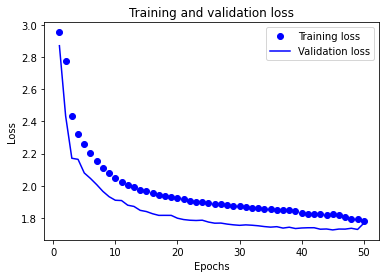

In [382]:
loss = history_a.history['loss']
val_loss = history_a.history['val_loss']

epochs = range(1, len(loss) + 1)


plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

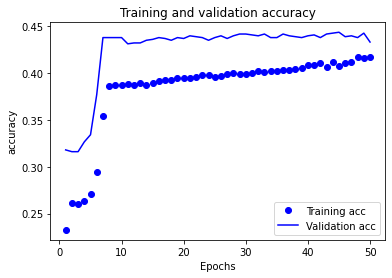

In [383]:
plt.clf()   # clear figure

acc = history_a.history['accuracy']
val_acc = history_a.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()

plt.show()

In [384]:
print("Evaluate on test data Arabic")
results = model.evaluate(x_test_a, y_test_a)
print("test loss: {} ".format(results[0]))
print("test accuracy: {} ".format(results[1]))

Evaluate on test data Arabic
2/2 [==============================] - 0s 24ms/step - loss: 1.7664 - accuracy: 0.4333
test loss: 1.7663702964782715 
test accuracy: 0.4333333373069763 


In [ ]:
reverse_tag_dict_a = {v: k for k, v in tag_dict_a.items()}

In [398]:
y_predict_lst_a = []
for record in x_test_a:
    y_predict_lst_a.append(predict(record,model))
y_true_lst_a =y_test_a


y_true_flat_a = np.reshape(y_true_lst_a, (-1,))
y_predict_flat_a = np.reshape(y_predict_lst_a, (-1,))

tag_true_list_a , tag_predict_list_a = get_tags(reverse_tag_dict_a,y_true_flat_a,y_predict_flat_a)

1/1 [==============================] - 0s 495ms/step


In [399]:
f1 = f1_score(tag_true_list_a, tag_predict_list_a,average='micro')
f1

0.44761904761904764

- Model 2

In [400]:
model2 = Sequential()
model2.add(LSTM(units=248, input_shape=(max_len_a, embedding_dim_a), return_sequences=True))
model2.add(LSTM(units=128, return_sequences=True))
model2.add(LSTM(units=64,  return_sequences=True))
model2.add(LSTM(units=64,  return_sequences=True))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(len(tag_dict_a), activation='softmax'))
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model2.summary()


Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_57 (LSTM)              (None, 30, 248)           346208    
                                                                 
 lstm_58 (LSTM)              (None, 30, 128)           193024    
                                                                 
 lstm_59 (LSTM)              (None, 30, 64)            49408     
                                                                 
 lstm_60 (LSTM)              (None, 30, 64)            33024     
                                                                 
 dense_51 (Dense)            (None, 30, 64)            4160      
                                                                 
 dense_52 (Dense)            (None, 30, 64)            4160      
                                                                 
 dense_53 (Dense)            (None, 30, 20)          

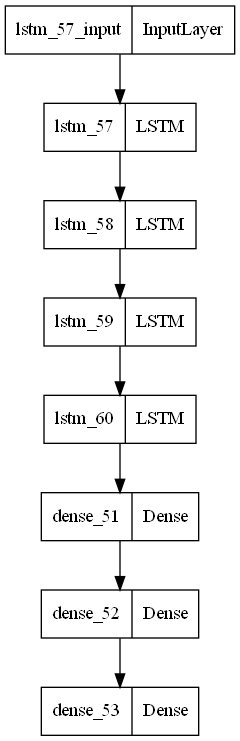

In [401]:
plot_model(model2)

In [402]:
history_a2=model2.fit(x_train_a, y_train_a, epochs=50, batch_size=32, validation_data=(x_test_a, y_test_a))


Epoch 1/50
10/10 [==============================] - 46s 2s/step - loss: 2.8800 - accuracy: 0.2400 - val_loss: 2.4965 - val_accuracy: 0.3152
Epoch 2/50
10/10 [==============================] - 17s 2s/step - loss: 2.5269 - accuracy: 0.2605 - val_loss: 2.3308 - val_accuracy: 0.3152
Epoch 3/50
10/10 [==============================] - 17s 2s/step - loss: 2.3673 - accuracy: 0.2979 - val_loss: 2.1799 - val_accuracy: 0.3981
Epoch 4/50
10/10 [==============================] - 16s 2s/step - loss: 2.2669 - accuracy: 0.3512 - val_loss: 2.0804 - val_accuracy: 0.4095
Epoch 5/50
10/10 [==============================] - 14s 1s/step - loss: 2.2284 - accuracy: 0.3545 - val_loss: 2.0564 - val_accuracy: 0.4076
Epoch 6/50
10/10 [==============================] - 12s 1s/step - loss: 2.1709 - accuracy: 0.3566 - val_loss: 2.0428 - val_accuracy: 0.4076
Epoch 7/50
10/10 [==============================] - 13s 1s/step - loss: 2.1396 - accuracy: 0.3599 - val_loss: 2.1012 - val_accuracy: 0.3962
Epoch 8/50
10/10 [==

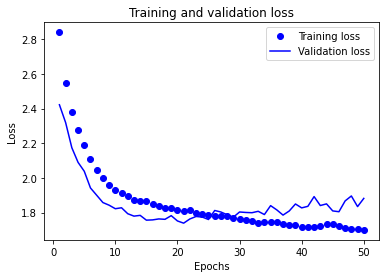

In [396]:
loss = history_a2.history['loss']
val_loss = history_a2.history['val_loss']

epochs = range(1, len(loss) + 1)


plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

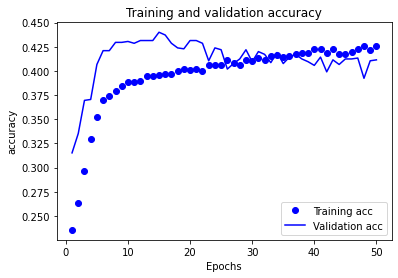

In [397]:
plt.clf()   # clear figure

acc = history_a2.history['accuracy']
val_acc = history_a2.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()

plt.show()

##### Early stopping in epoch 30

In [405]:
y_predict_lst_a2 = []
for record in x_test_a:
    y_predict_lst_a2.append(predict(record,model2))

y_predict_flat_a2 = np.reshape(y_predict_lst_a2, (-1,))

tag_true_list_a , tag_predict_list_a2 = get_tags(reverse_tag_dict_a,y_true_flat_a,y_predict_flat_a2)

1/1 [==============================] - 0s 173ms/step


In [406]:
f1 = f1_score(tag_true_list_a, tag_predict_list_a2,average='micro')
f1

0.41523809523809524

In [ ]:
word_index_a = tokenizer_a.word_index
reverse_word_index_a = dict([(value, key) for (key, value) in word_index_a.items()])
embedding_weights_a = embedding_layer_a.get_weights()[0]

In [373]:
i = random.randint(0,len(x_test_a))
print(i) 
original_sen , true_tag , predicted_tag = predict_and_display(x_test_a[i],y_test_a[i],model,reverse_word_index_a,reverse_tag_dict_a)


original_sen_lst = original_sen.split()
print('original sentence','\t','true tag','\t','predicted tag')
for i in range(len(true_tag)):
    
    print(original_sen_lst[i],'\t\t\t',true_tag[i],'\t\t\t',predicted_tag[i])

4
1/1 [==============================] - 1s 1s/step
original sentence 	 true tag 	 predicted tag
في 			 ADJ 			 PART
عليها 			 NOUN 			 PART
غير 			 PREP 			 NOUN
الواحد 			 DET 			 NOUN
عن 			 DET 			 NOUN
عايز 			 PRON 			 NOUN
فيه 			 PROG_PART 			 NOUN
eos 			 NOUN 			 NOUN
هو 			 NOUN 			 NOUN
طب 			 PUNC 			 NOUN
أنا 			 PUNC 			 NOUN
البلد 			 PRON 			 NOUN
فيه 			 PRON 			 NOUN
عليها 			 PART 			 NOUN
غير 			 V 			 NOUN
كلام 			 NOUN 			 NOUN
دي 			 FUT_PART 			 NOUN
ولا 			 NOUN 			 NOUN
بقى 			 PART 			 NOUN
اني 			 PUNC 			 NOUN
اني 			 EOS 			 NOUN
اني 			 NUM 			 NOUN
اني 			 NUM 			 NOUN
اني 			 NUM 			 NOUN
اني 			 NUM 			 NOUN
اني 			 NUM 			 NOUN
اني 			 NUM 			 NOUN
اني 			 NUM 			 NOUN
اني 			 NUM 			 NUM
اني 			 NUM 			 NUM


In [374]:
lst = []
for i in range(len(original_sen.split())):
    sen = original_sen.split()
    if true_tag[i].lower() == 'eos':
        break
    else:
        lst.append((sen[i],true_tag[i]))
lst

[('في', 'ADJ'),
 ('عليها', 'NOUN'),
 ('غير', 'PREP'),
 ('الواحد', 'DET'),
 ('عن', 'DET'),
 ('عايز', 'PRON'),
 ('فيه', 'PROG_PART'),
 ('eos', 'NOUN'),
 ('هو', 'NOUN'),
 ('طب', 'PUNC'),
 ('أنا', 'PUNC'),
 ('البلد', 'PRON'),
 ('فيه', 'PRON'),
 ('عليها', 'PART'),
 ('غير', 'V'),
 ('كلام', 'NOUN'),
 ('دي', 'FUT_PART'),
 ('ولا', 'NOUN'),
 ('بقى', 'PART'),
 ('اني', 'PUNC')]

## Pretrained

In [407]:
tagger = FarasaPOSTagger()


In [413]:
text = ' '.join(df['words'][3])
pos_tags = tagger.tag(text)

print(text)
print(pos_tags)
print(df['pos_tags'][3])

بحس بشخصيتي القوية لما اقول لاخويا اعمل حاجة . . و يعملها . . حتي لو رخم و قال لأ . . بحس اني شخصية كدا و بتسمع كلامي ^_^ EOS
S/S ب+/PREP حس/NOUN-MS ب+/PREP شخصي +ت/NOUN+NSUFF-FD +ي/PRON ال+ قوي +ة/DET+ADJ+NSUFF-FP ل+/PREP +ما/PART أقول/V ل+/PREP اخوي/NOUN-MS +ا/CASE أعمل/V حاج +ة/NOUN+NSUFF-FS ./PUNC ./PUNC و/CONJ يعمل/V +ها/PRON ./PUNC ./PUNC حتي/NOUN-MS لو/PART رخم/V و/CONJ قال/V لأ/NOUN-MS ./PUNC ./PUNC ب+/PREP حس/NOUN-MS ان/NOUN-MS +ي/PRON شخصي +ة/NOUN+NSUFF-FS كدا/NOUN-MS و/CONJ ب+/PREP تسمع/V ك+/PREP لامي/NOUN-MS ^/FOREIGN _/FOREIGN ^/FOREIGN EOS/FOREIGN E/E
['PROG_PART', 'PREP', 'DET', 'PART', 'V', 'PREP', 'V', 'NOUN', 'PUNC', 'PUNC', 'CONJ', 'V', 'PUNC', 'PUNC', 'PART', 'PART', 'V', 'CONJ', 'V', 'PART', 'PUNC', 'PUNC', 'PROG_PART', 'PART', 'NOUN', 'ADV', 'CONJ', 'PROG_PART', 'NOUN', 'EMOT', 'EOS']


In [426]:
true_tag = df['pos_tags'][3]

In [422]:
sen = df['words'][3]


In [423]:
arabic_tags = []
for i in range(len(sen)):
    arabic_tags.append((sen[i],true_tag[i]))
arabic_tags

[('بحس', 'PROG_PART'),
 ('بشخصيتي', 'PREP'),
 ('القوية', 'DET'),
 ('لما', 'PART'),
 ('اقول', 'V'),
 ('لاخويا', 'PREP'),
 ('اعمل', 'V'),
 ('حاجة', 'NOUN'),
 ('.', 'PUNC'),
 ('.', 'PUNC'),
 ('و', 'CONJ'),
 ('يعملها', 'V'),
 ('.', 'PUNC'),
 ('.', 'PUNC'),
 ('حتي', 'PART'),
 ('لو', 'PART'),
 ('رخم', 'V'),
 ('و', 'CONJ'),
 ('قال', 'V'),
 ('لأ', 'PART'),
 ('.', 'PUNC'),
 ('.', 'PUNC'),
 ('بحس', 'PROG_PART'),
 ('اني', 'PART'),
 ('شخصية', 'NOUN'),
 ('كدا', 'ADV'),
 ('و', 'CONJ'),
 ('بتسمع', 'PROG_PART'),
 ('كلامي', 'NOUN'),
 ('^_^', 'EMOT'),
 ('EOS', 'EOS')]

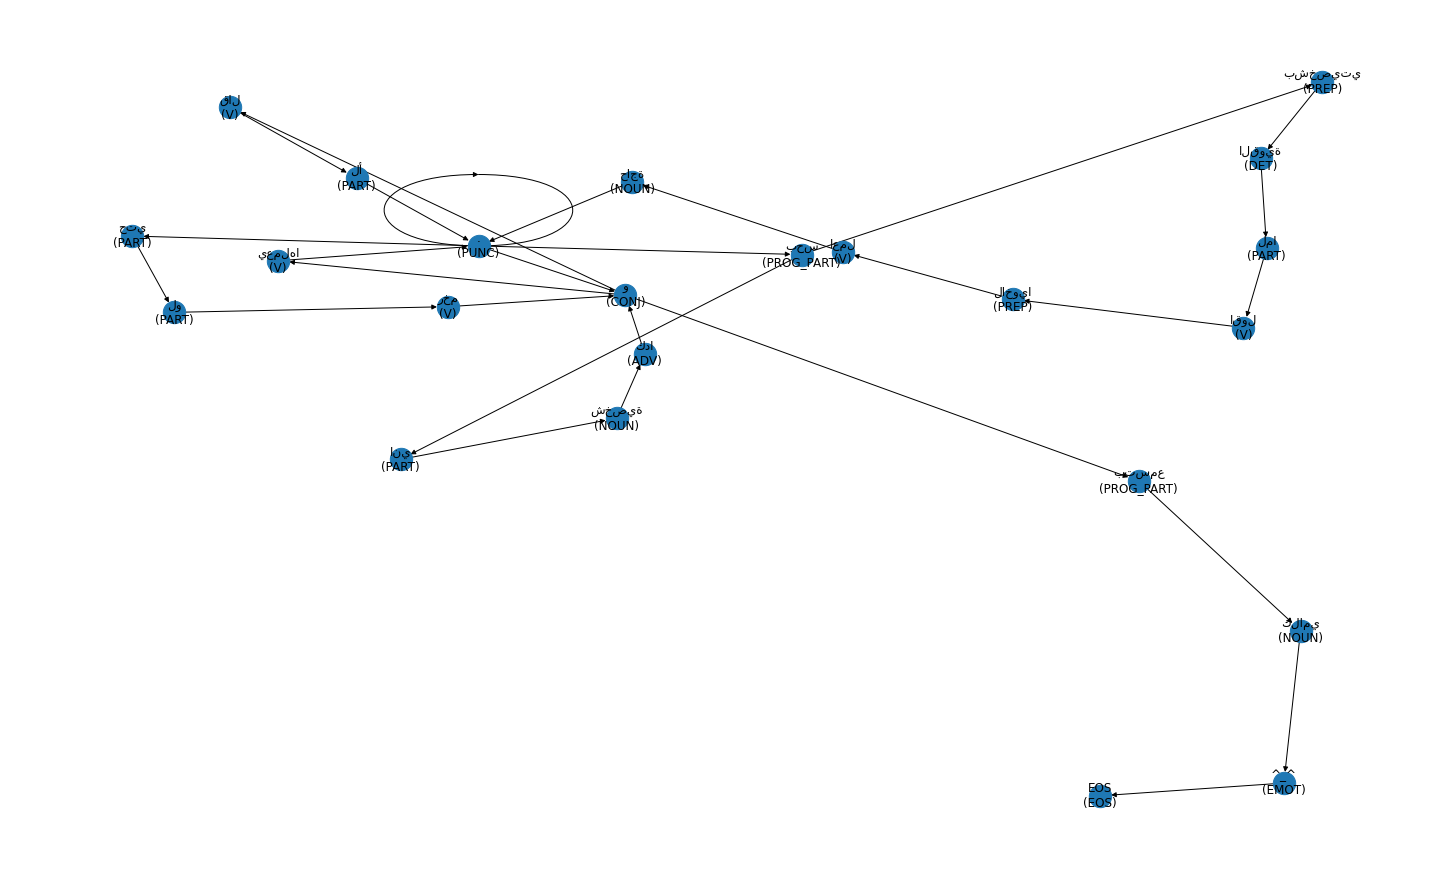

In [433]:

graph = nx.DiGraph()

# Add nodes for each word and its POS tag
for word, pos in arabic_tags:
    node_label = f"{word}\n({pos})"  
    graph.add_node(node_label)

# Add edges between adjacent words
for i in range(len(arabic_tags) - 1):
    start_label = f"{arabic_tags[i][0]}\n({arabic_tags[i][1]})"
    end_label = f"{arabic_tags[i+1][0]}\n({arabic_tags[i+1][1]})"
    graph.add_edge(start_label, end_label)

plt.figure(3,figsize=(20,12)) 
pos = nx.spring_layout(graph)  
nx.draw(graph, pos, with_labels=True,node_size=500)
